In [36]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import create_mesh, variation_dim, mesh_dim, create_mesh_dict, BylMesh
import time
import copy
import gym


import xarray as xr
import numpy as np
import pandas as pd

import os

from sklearn.decomposition import PCA

In [243]:
def identity(rews,obs,acts):
    return rews

def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)

def varmul(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)

def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            input("step?")
            #time.sleep(.05)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


def do_long_rollout(env, policy, ep_length):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length

<Figure size 432x288 with 0 Axes>

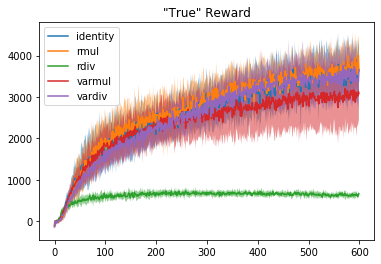

<Figure size 432x288 with 0 Axes>

In [244]:
data = torch.load("./data4/HalfCheetah-v2.xr")

policy_dict = data.policy_dict
rews = data.rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict['identity'])

#policy_dict = torch.load("./data/mjw_longermul.pol_dict")
#rews = torch.load("./data/mjw_longermul.data")

means = rews.mean(dim="trial")
stds = rews.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names)
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("\"True\" Reward")
plt.figure()

# for exp_name in exp_names:  
#     plt.plot(rews.loc[exp_name].T)
#     plt.title(exp_name)
#     plt.figure()

cycles found:  180.0


<Figure size 432x288 with 0 Axes>

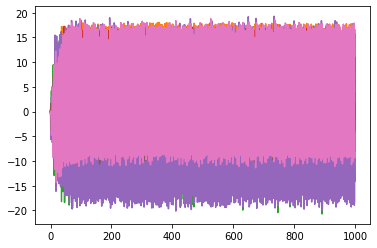

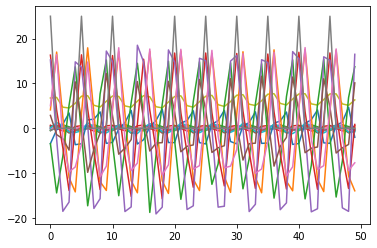

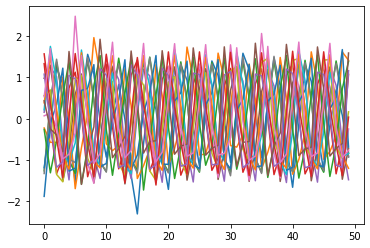

<Figure size 432x288 with 0 Axes>

In [266]:
from sklearn.decomposition import PCA
env_name = "HalfCheetah-v2"

policy = policy_dict['vardiv'][5]
env = gym.make(env_name)
obs,acts,rews,l = do_long_rollout(env, policy, ep_length= 1000)
#o,a,r,l = do_rollout(env, policy, render=True)

on = np.zeros(obs.shape[0])
for i,o in enumerate(obs):
    on[i] = (o[3] > .5 and o[12] < 0.0 and last_o[12] > 0.0 and step > 10)
    last_o = copy.deepcopy(o)

print("cycles found: ", sum(on))

start_idx = 100; end_idx = 150
plt.plot(obs)
plt.figure()
plt.plot(obs[start_idx:end_idx])
plt.plot(on[start_idx:end_idx]*25)
plt.figure()
ref = np.array(obs[start_idx:end_idx],dtype=np.float64)
target = (ref - ref.mean(axis=0))/ref.std(axis=0)
target = copy.deepcopy(target) # Don't even ask
plt.plot(target)
plt.figure()

In [253]:
#target = np.random.random((500,11))
#target = np.array(o[start_idx:])
pca = PCA(svd_solver='arpack')
pca.fit(target)

PCA(svd_solver='arpack')

In [169]:
np.cumsum(pca.explained_variance_ratio_)

array([0.48827693, 0.92413488, 0.9561118 , 0.97827858, 0.99029819,
       0.99310216, 0.99507068, 0.99665668, 0.99778584, 0.99855633,
       0.99907325, 0.99938739, 0.99960122, 0.99976693, 0.99985638,
       0.99993658])

In [170]:
pca.singular_values_/pca.singular_values_.max()

array([1.        , 0.94479891, 0.25590879, 0.21306796, 0.15689612,
       0.07577985, 0.0634946 , 0.05699258, 0.0480888 , 0.0397239 ,
       0.03253699, 0.02536458, 0.02092675, 0.01842216, 0.01353476,
       0.01281648])

In [149]:
dl = []
last_seen = 0
for i,o in enumerate(on):
    if o == 1:
        dl.append(i-last_seen)
        last_seen = i
        
dd = {}
for d in dl:
    if (d) in dd: 
        dd[(d)] += 1
    else:
        dd[(d)] = 1
        
for thing in dd.items():
    print("spacing: ", thing[0], " frequency: ", thing[1])

spacing:  22  frequency:  1
spacing:  9  frequency:  41
spacing:  27  frequency:  2
spacing:  18  frequency:  5
spacing:  41  frequency:  3
spacing:  23  frequency:  4
spacing:  32  frequency:  7
spacing:  5  frequency:  1
spacing:  4  frequency:  1
spacing:  14  frequency:  1


In [284]:
# HalfCheetah-v2
def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:8]))
    qvel = point[8:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()


def create_mesh_act(env, policy, d, seed_point, perturbs):
    torch.autograd.set_grad_enabled(False)
    
    failure_point = np.ones_like(seed_point)*10
    
    mesh = BylMesh(d) 
    mesh[failure_point] = [0, 0, failure_point]
    mesh[seed_point] = [1, 0, seed_point]

    
    mesh_points = []
    mesh_points.append(failure_point)
    mesh_points.append(seed_point)
    
    transition_list = [[0]*len(perturbs)] #Failure state always transitions to itself
    
    cnt = 0; cur_explored_cnt = 0
    for init_pos in mesh_points:
        if (init_pos == failure_point).all():
            continue
        
        cur_explored_cnt += 1
        cur_mesh_pnt = len(mesh_points)
        transition_list.append([])

        tmp_points = []
        tmp_keys = []
        failed = False

        for pert in perturbs:
            if failed:
                break
            cnt+=1


            step = 0
            done = False; 
            do_once=1 
            o = my_reset(env, init_pos)

            while not done:
                a = policy(o) + do_once*pert
                step+=1
                do_once=0
                
                last_o = copy.copy(o)

                o, r, done, _ = env.step(a.numpy())

                
                if (o[3] > .5 and o[12] < 0.0 and last_o[12] > 0.0 and step > 7):
                    m = o[12] - last_o[12]
                    b = last_o[12]
                    tcross = -b/m
                    pt = last_o + tcross*(o - last_o)
                                    
                    key = (pt - ref.mean(axis=0))/ref.std(axis=0)
                    
                    #weights = pca.singular_values_/pca.singular_values_.max()
                    #key = weights*pca.transform(key.reshape(1,-1)).reshape(-1)

                    tmp_points.append(copy.copy(pt))
                    tmp_keys.append(copy.copy(key))

                    if cnt % 1000 == 0:
                        print("explored: ", cur_explored_cnt, "| added: ", len(mesh), "| ratio: ", cur_explored_cnt/len(mesh), "| failures: ", mesh[failure_point][1], "| count: ", cnt)
                    done=True
                        
                if step > 200:
                    failed=True
                    done=True
                    
        if not failed:
            for p,k in zip(tmp_points, tmp_keys):
                if k in mesh:
                    mesh[k][1] += 1
                else:
                    mesh_points.append(p)
                    mesh[k] = [1, len(mesh_points), p]
                    
                transition_list[-1].append(mesh[k][1])


        else:
            for _ in range(len(perturbs)):
                mesh[failure_point][1] += 1
                transition_list[-1].append(mesh[failure_point][0])

  
    torch.autograd.set_grad_enabled(True)
    return mesh, mesh_points, np.array(transition_list)

  

In [ ]:
perts =  np.random.uniform(-.1,.1,(10,6))
#perts = np.zeros((100,17))

o = env.reset()
last_o = copy.copy(o)

step = 0
done=False
ol = [] 
while not done:
    a = policy(o).detach(); step+=1
    o, r, done, _ = env.step(a.numpy())
    if (o[3] > .5 and o[12] < 0.0 and last_o[12] > 0.0 and step > 100):
        seed_point = o
        done=True
    last_o = copy.copy(o)

print(seed_point)
mesh, mesh_points, T = create_mesh_act(env, policy, .5, seed_point, perts)

[-0.14867627 -0.12123821 -0.50628478  0.63457058  0.25370441  0.2877294
  0.34602195 -0.52964529  7.96662314 -0.39823813 -3.42170427  3.98434902
 -2.09779059 16.72891798 15.37650424  2.23581575 -1.49270016]
explored:  100 | added:  634 | ratio:  0.15772870662460567 | failures:  0 | count:  1000
explored:  200 | added:  984 | ratio:  0.2032520325203252 | failures:  0 | count:  2000
explored:  300 | added:  1393 | ratio:  0.21536252692031588 | failures:  0 | count:  3000
explored:  400 | added:  1683 | ratio:  0.23767082590612001 | failures:  0 | count:  4000
explored:  504 | added:  1981 | ratio:  0.254416961130742 | failures:  50 | count:  5000
explored:  611 | added:  2470 | ratio:  0.24736842105263157 | failures:  120 | count:  6000
explored:  711 | added:  2697 | ratio:  0.26362625139043383 | failures:  130 | count:  7000
explored:  811 | added:  2903 | ratio:  0.2793661729245608 | failures:  130 | count:  8000
explored:  911 | added:  3169 | ratio:  0.2874723887661723 | failures:  

In [273]:
failure_point = np.ones_like(seed_point)*10
print(len(mesh[failure_point]))
print(len(mesh))
print(len(mesh_points))

3
12
12


In [275]:
from scipy import sparse 
Ts = sparse.lil_matrix((T.shape[0], T.shape[0]))
for i,t in enumerate(T):
    #print(i)
    for e in t:
        Ts[i,e] += 1/len(t)
    

IndexError: column index (3) out of bounds

In [232]:
w,v = sparse.linalg.eigs(Ts,k=10)

In [233]:
w

array([ 1.        +0.j        ,  0.39445753-0.30956076j,
        0.39445753+0.30956076j,  0.44682736-0.09112452j,
        0.44682736+0.09112452j, -0.27134617-0.30769433j,
       -0.27134617+0.30769433j,  0.1927448 -0.31862573j,
        0.1927448 +0.31862573j, -0.33359028-0.09321951j])

In [234]:
v.shape

(731, 10)

In [228]:
T

array([[  2,   3,   4, ...,   8,   4,   9],
       [ 10,   6,   2, ...,   4,  12,   8],
       [ 13,  14,   2, ...,  19,  20,  19],
       ...,
       [337,  89,  86, ...,  86, 159,  87],
       [174, 124, 459, ..., 368, 348, 438],
       [538,  75, 165, ..., 174, 220, 174]])